In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import add_constant

from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, roc_auc_score # ROC-curve and AUC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier # градиентный бустинг & случайный лес
import matplotlib.pyplot as plt

# Не показывать FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Данные с [сайта](https://pages.stern.nyu.edu/~wgreene/Text/econometricanalysis.htm), датасет Table F7.3: Expenditure and Default Data, 13,444 observations

Source: Greene (1992)

- Cardhldr = Dummy variable, 1 if application for credit card accepted, 0 if not
- Default = 1 if defaulted 0 if not (observed when Cardhldr = 1, 10,499 observations),
- Age = Age in years plus twelfths of a year,
- Adepcnt = 1 + number of dependents,
- Acadmos = months living at current address,
- Majordrg = Number of major derogatory reports,
- Minordrg = Number of minor derogatory reports,
- Ownrent = 1 if owns their home, 0 if rent
- Income = Monthly income (divided by 10,000),
- Selfempl = 1 if self employed, 0 if not,
- Inc_per = Income divided by number of dependents,
- Exp_Inc = Ratio of monthly credit card expenditure to yearly income,
- Spending = Average monthly credit card expenditure (for Cardhldr = 1),
- Logspend = Log of spending.

In [2]:
# подключим датасет по ссылке 
df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/econometrica/main/econometrica2/data-csv/TableF7-3.csv', na_values=(' ', '', '  '))
#подключим датасет из локального файла
#df = pd.read_csv('TableF7-3.csv', na_values=(' ', '', '  '))
df.head()

,CARDHLDR,DEFAULT,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,INCOME,SELFEMPL,INCPER,EXP_INC,SPENDING,LOGSPEND
0,0,0,27.250000,4,0,0,0,0,1200.000000,0,18000.0,0.000667,NaN,NaN
1,0,0,40.833332,111,3,0,0,1,4000.000000,0,13500.0,0.000222,NaN,NaN
2,1,0,37.666668,54,3,0,0,1,3666.666667,0,11300.0,0.033270,121.989677,4.803936
3,1,0,42.500000,60,3,0,0,1,2000.000000,0,17250.0,0.048427,96.853621,4.573201
4,1,0,21.333334,8,0,0,0,0,2916.666667,0,35000.0,0.016523,48.191670,3.875186


In [3]:
# информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13444 entries, 0 to 13443
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CARDHLDR  13444 non-null  int64  
 1   DEFAULT   13444 non-null  int64  
 2   AGE       13444 non-null  float64
 3   ACADMOS   13444 non-null  int64  
 4   ADEPCNT   13444 non-null  int64  
 5   MAJORDRG  13444 non-null  int64  
 6   MINORDRG  13444 non-null  int64  
 7   OWNRENT   13444 non-null  int64  
 8   INCOME    13444 non-null  float64
 9   SELFEMPL  13444 non-null  int64  
 10  INCPER    13444 non-null  float64
 11  EXP_INC   13444 non-null  float64
 12  SPENDING  10499 non-null  float64
 13  LOGSPEND  10499 non-null  float64
dtypes: float64(6), int64(8)
memory usage: 1.4 MB


Переменные `SPENDING` и `LOGSPEND` содержат пропуски. 

**ЗАМЕЧАНИЕ**. При задании матриц регрессионного дизайна нужно обработать пропуски, если модель будет содержать указанные регрессоры.

### Зададим спецификацию модели через матрицы регрессионного дизайна

Рассмотрим logit регрессию `DEFAULT` на `CARDHLDR, AGE, ACADMOS, ADEPCNT, MAJORDRG, MINORDRG, OWNRENT, INCOME, SELFEMPL, INCPER, EXP_INC`

In [4]:
# зададим зависимую переменную
y = df['DEFAULT']
# Добавляем столбец с единицами к матрице регрессоров (признаков), искллючив из нее переменные DEFAULT, SPENDING, LOGSPEND
X = add_constant(df.drop(columns=['DEFAULT', 'SPENDING','LOGSPEND']))
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [5]:
# зададим спецификацию модели
mod_logit = sm.Logit(endog=y_train, exog=X_train)
# подгонка модели
res_logit = mod_logit.fit()

         Current function value: 0.235682
         Iterations: 35


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


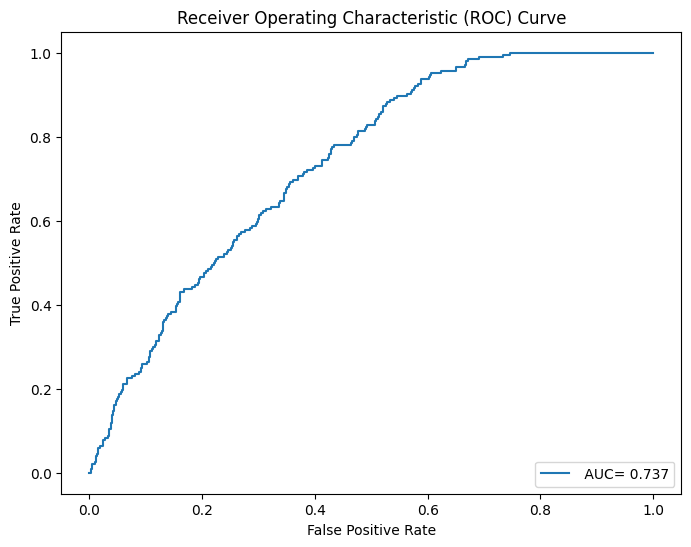

In [6]:
# строим прогнозы для тестового набора данных по логит-модели
y_pred_prob = res_logit.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
# fpr False Positive Rate
# tpr True Positive Rate
# threshold пороговые значения вероятностей

# вычисляем площадь под ROC-кривой
auc_roc = roc_auc_score(y_test, y_pred_prob)
# построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot (fpr, tpr, label=" AUC= %0.3f" % auc_roc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Сравним logit и probit модели регрессий

In [7]:
# зададим спецификацию модели
mod_probit = sm.Probit(endog=y_train, exog=X_train)
# подгонка модели
res_probit = mod_probit.fit()

         Current function value: 0.235853
         Iterations: 35


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


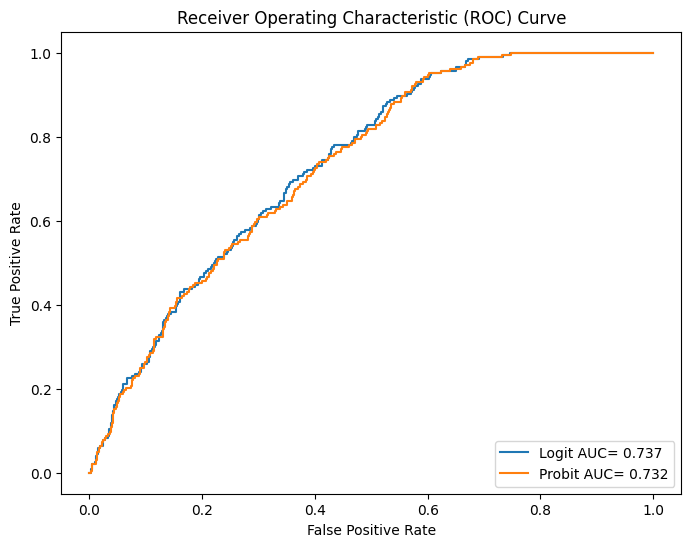

In [8]:
# строим прогнозы для тестового набора данных по логит-модели
y_pred_prob = res_logit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# вычисляем площадь под ROC-кривой
auc_roc = roc_auc_score(y_test, y_pred_prob)

# построение ROC-кривой
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot (fpr,tpr,label="Logit AUC= %0.3f" % auc_roc)

# строим прогнозы для тестового набора данных по пробит-модели
y_pred_prob = res_probit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# вычисляем площадь под ROC-кривой
auc_roc = roc_auc_score(y_test, y_pred_prob)

# построение ROC-кривой
plt.plot (fpr,tpr,label="Probit AUC= %0.3f" % auc_roc)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Сравним logit-регрессию с другими моделями

- с регрессией без предикторов `mod_logit_null`
- с градиентным бустингом `grad_boost`
- с моделью случайного леса `rand_forest`

In [9]:
mod_logit_null = sm.Logit(endog=y_train, exog=np.ones(len(y_train)))
res_logit_null = mod_logit_null.fit()

Optimization terminated successfully.
         Current function value: 0.262955
         Iterations 6


In [10]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

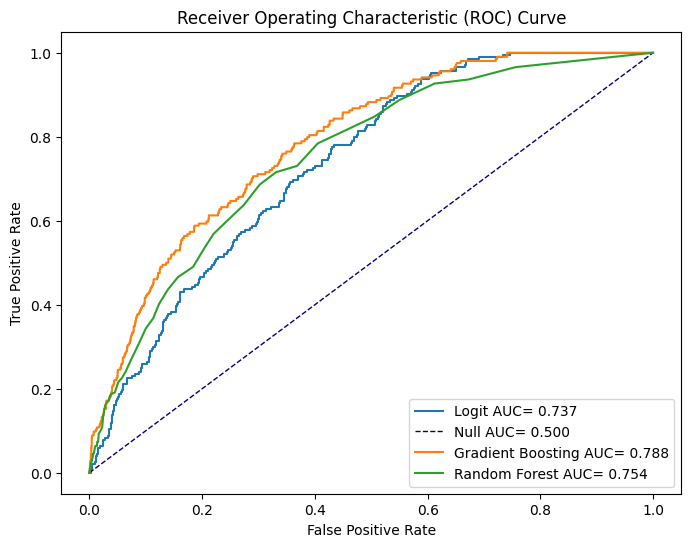

In [12]:
y_pred_prob = res_logit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

auc_roc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, label="Logit AUC= %0.3f" % auc_roc)

y_pred_prob = res_logit_null.predict(np.ones(len(y_test)))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

auc_roc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, color='navy', lw=1, linestyle='--', label="Null AUC= %0.3f" % auc_roc)

y_pred_prob = grad_boost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

auc_roc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label="Gradient Boosting AUC= %0.3f" % auc_roc)

y_pred_prob = rand_forest.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

auc_roc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label="Random Forest AUC= %0.3f" % auc_roc)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()